# Predict the stock market

### Set up

In [1]:
# Set un the environment
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import nltk
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.preprocessing import FunctionTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

c:\users\henon\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## Preprocessing

In [15]:
path_1 = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\combined_stock_data.csv'
path_2 = r'C:\Users\henon\code\Stock_market\STOCK_PREDICT\data\upload_DJIA_table.csv'
df_news = pd.read_csv(path_1)
df_djia = pd.read_csv(path_2)

In [16]:
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_djia['Date'] = pd.to_datetime(df_djia['Date'])

In [17]:
df = df_news[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive','Negative', 'Neutral']].merge(df_djia)

In [18]:
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

df['change'] = df['Open'].pct_change()
# remove first row
df['change'] = df['change'].shift(-1)
df['target'] = df['change'].apply(categorical)

In [19]:
df.index = df.index.sort_values()

In [20]:
df.head()

,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,change,target
0,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.244438,0
1,2008-12-08,0,56.250000,43.750000,18.750000,37.500000,43.750000,8637.650391,9026.410156,8637.490234,8934.179688,358970000,8934.179688,0.346756,1
2,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.008660,0
3,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.006863,1
4,2008-08-15,1,70.000000,30.000000,10.000000,60.000000,30.000000,11611.209961,11709.889648,11599.730469,11659.900391,215040000,11659.900391,0.004172,1


### Clean the text

In [21]:
cols = df_news.columns[3:28]
df_news['combined'] = df_news[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [22]:
def clean(text):
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punctuation in punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    text=text.lower() # Lower Case
    text=text.replace("b ","")
    text=text.replace("b'","")
    text=text.replace('b"',"")
    text = ''.join(c for c in text if not c.isdigit())
    tokenized = word_tokenize(text) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return " ".join(lemmatized)

In [23]:
df_news['cleaned'] = df_news['combined'].apply(clean)

In [24]:
df = df_news[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive','Negative', 'Neutral', 'cleaned']].merge(df_djia)

### Fix target variable

In [25]:
def categorical(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

df['change'] = df['Open'].pct_change()
# remove first row
df['change'] = df['change'].shift(-1)
df['target'] = df['change'].apply(categorical)

In [26]:
df.index = df.index.sort_values()

## Heatmap of features

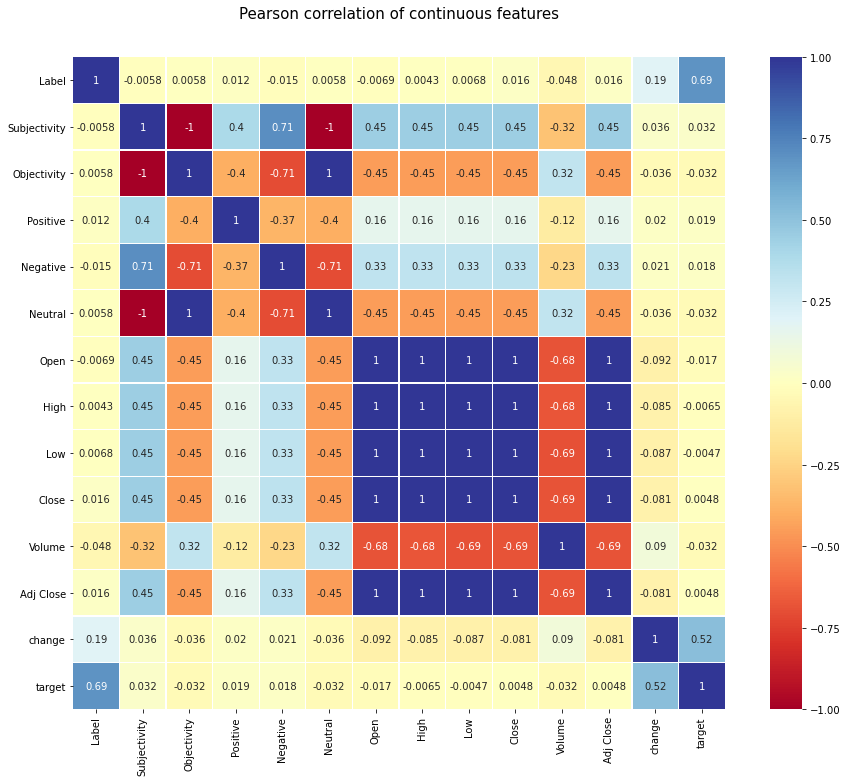

In [27]:
colormap = pyplot.cm.RdYlBu
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

## Preprocessing and cleaning

### Missing values

In [28]:
# Dataframe drop missing value due to change
df = df.iloc[:-1]

In [29]:
# Replace missing values with mean
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    df[col] = df[col].fillna(df[col].mean())

In [30]:
df.isnull().sum()

Date            0
Label           0
Subjectivity    0
Objectivity     0
Positive        0
Negative        0
Neutral         0
cleaned         0
Open            0
High            0
Low             0
Close           0
Volume          0
Adj Close       0
change          0
target          0
dtype: int64

In [31]:
df.shape

(1729, 16)

### Train test split

In [32]:
# Define y
y = df['target']

In [33]:
df.loc[0]

Date                                          2008-08-08 00:00:00
Label                                                           0
Subjectivity                                                   75
Objectivity                                                    25
Positive                                                    18.75
Negative                                                    56.25
Neutral                                                        25
cleaned         georgia down two russian warplane country move...
Open                                                      11432.1
High                                                        11760
Low                                                         11388
Close                                                     11734.3
Volume                                                  212830000
Adj Close                                                 11734.3
change                                                  -0.244438
target    

In [34]:
# Define eligible Y variable
X = df.drop('Label', axis = 1)
X = X.drop('target', axis = 1)
X = X.drop('Date', axis = 1)
X = X.drop('change', axis = 1)
X = X.drop('cleaned', axis = 1)

In [35]:
X.shape

(1729, 11)

In [36]:
# Split dataset
train_size = int(len(X.index) * 0.7)

X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1211, 11), (519, 11), (1211,), (519,))

In [37]:
# Scale variables
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Machine Learning Modelling

In [38]:
scoring = 'precision'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [39]:
import warnings; warnings.simplefilter('ignore')

# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.7514450867052023
LDA: 0.7996146435452793
KNN: 0.5028901734104047
CART: 0.5240847784200385
NB: 0.5529865125240848
SVM: 0.5433526011560693
RF: 0.5105973025048169


In [40]:
import warnings; warnings.simplefilter('ignore')

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

LR: 0.692044 (0.089430)
LDA: 0.761807 (0.090641)
KNN: 0.547220 (0.064724)
CART: 0.566570 (0.067500)
NB: 0.557423 (0.057587)
SVM: 0.570394 (0.061491)
RF: 0.573782 (0.063951)


### Linear Discriminant Analysis

In [41]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(X_test)
print("accuracy score:")
print(accuracy_score(y_test, predictions))

accuracy score:
0.7996146435452793


roc auc is :0.8315552891818998


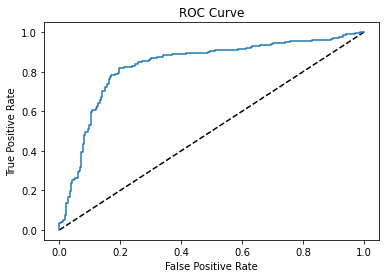

AUC using cross val: [0.8035982  0.78921569 0.91851852 0.76344086 0.86607143 0.9047619
 0.83703704 0.78648233 0.91993464 0.82580645]
Mean AUC score is: 0.8414867063283215


In [42]:
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=10, random_state=42)
auc_score = cross_val_score(model_lda, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

## XGBoost feature selection


In [45]:
import seaborn as sns
ax = sns.scatterplot(x="Open", y="Volume", hue='polarity',data= df)

ValueError: Could not interpret input 'polarity'

## Doc similarity

In [350]:
text1

'georgia down two russian warplane country move rink war reaking musharraf e impeached russia today column troop roll south ossetia footage fighting youtue russian tank moving towards capital south ossetia reportedly een completely destroyed georgian artillery fire afghan child raped impunity u n official say sick three year old raped nothing russian tank entered south ossetia whilst georgia shoot two russian jet reaking georgia invades south ossetia russia warned would intervene side enemy comatent trial nothing ut sham salim haman een sentenced year ut e kept longer anyway ecause feel like georgian troop retreat osettain capital presumaly leaving several hundred people killed video u prep georgia war russia rice give green light israel attack iran say u veto israeli military ops announcing class action lawsuit ehalf american pulic fi russia georgia war nyt top story opening ceremony olympics fucking disgrace yet proof decline journalism china tell ush stay country affair world war ii

In [400]:
other = df[13:]

In [401]:
# Program to measure similarity between  
# two sentences using cosine similarity. 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def similarity(text2):
    text1 = df['cleaned'][10]
    # tokenization 
    X_list = word_tokenize(text1)  
    Y_list = word_tokenize(text2) 
  
    # sw contains the list of stopwords 
    sw = stopwords.words('english')  
    l1 =[];l2 =[] 
  
    # remove stop words from string 
    X_set = {w for w in X_list if not w in sw}  
    Y_set = {w for w in Y_list if not w in sw} 
  
    # form a set containing keywords of both strings  
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: l1.append(1) # create a vector 
        else: l1.append(0) 
        if w in Y_set: l2.append(1) 
        else: l2.append(0) 
    c = 0
  
    # cosine formula  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    return cosine
similarity(text2)

0.10413152017509349

In [402]:
other['similarity'] = df['cleaned'].apply(similarity)

c:\users\chris\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/

In [407]:
def invest():
    index = other[other['similarity'] == other['similarity'].max()].index[0]
    target = df['target'][index]
    if target == 1:
        print('It smells like money')
    if target == 0:
        print('you better buy your girlfriend a present than invest')
    print(index)
    print(target)


invest()

It smells like money
1524
1


## Reddit news scrapping

In [556]:
import datetime as dt
import json
import requests

text = []
today = dt.datetime.combine(dt.date.today(), dt.datetime.min.time())
response = requests.get('https://www.reddit.com/r/worldnews/top.json?limit=25', headers = {'User-agent': 'test'})
tops = json.loads(response.text)['data']['children']
for top in tops:
  if dt.datetime.fromtimestamp(top['data']['created']) >= today:
    text.append(top['data']['title'])
  else:
    text.append(top['data']['created'])

full = clean("".join(str(text)))
new_df = pd.DataFrame(data, columns = ['Date', 'cleaned'])
new_df

,Date,cleaned
0,2020-06-26,u remove saudi araia list worst human traffick...


## Yahoo finance scrapping

In [559]:
import requests
from bs4 import BeautifulSoup


URL = 'https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')


In [569]:
from alpha_vantage.timeseries import TimeSeries

In [563]:
<table class="W(100%) M(0)" data-test="historical-prices"><thead><tr class="C($tertiaryColor) Fz(xs) Ta(end)"><th class="Ta(start) W(100px) Fw(400) Py(6px)"><span>Date</span></th><th class="Fw(400) Py(6px)"><span>Open</span></th><th class="Fw(400) Py(6px)"><span>High</span></th><th class="Fw(400) Py(6px)"><span>Low</span></th><th class="Fw(400) Py(6px)"><span>Close*</span></th><th class="Fw(400) Py(6px)"><span>Adj Close**</span></th><th class="Fw(400) Py(6px)"><span>Volume</span></th></tr></thead><tbody><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 25, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,365.22</span></td><td class="Py(10px) Pstart(10px)"><span>25,769.61</span></td><td class="Py(10px) Pstart(10px)"><span>25,209.79</span></td><td class="Py(10px) Pstart(10px)"><span>25,745.60</span></td><td class="Py(10px) Pstart(10px)"><span>25,745.60</span></td><td class="Py(10px) Pstart(10px)"><span>384,560,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,992.96</span></td><td class="Py(10px) Pstart(10px)"><span>25,992.96</span></td><td class="Py(10px) Pstart(10px)"><span>25,296.73</span></td><td class="Py(10px) Pstart(10px)"><span>25,445.94</span></td><td class="Py(10px) Pstart(10px)"><span>25,445.94</span></td><td class="Py(10px) Pstart(10px)"><span>450,120,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 23, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,159.39</span></td><td class="Py(10px) Pstart(10px)"><span>26,314.97</span></td><td class="Py(10px) Pstart(10px)"><span>26,105.97</span></td><td class="Py(10px) Pstart(10px)"><span>26,156.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,156.10</span></td><td class="Py(10px) Pstart(10px)"><span>389,980,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 22, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,865.08</span></td><td class="Py(10px) Pstart(10px)"><span>26,059.81</span></td><td class="Py(10px) Pstart(10px)"><span>25,667.68</span></td><td class="Py(10px) Pstart(10px)"><span>26,024.96</span></td><td class="Py(10px) Pstart(10px)"><span>26,024.96</span></td><td class="Py(10px) Pstart(10px)"><span>351,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,213.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,451.44</span></td><td class="Py(10px) Pstart(10px)"><span>25,759.66</span></td><td class="Py(10px) Pstart(10px)"><span>25,871.46</span></td><td class="Py(10px) Pstart(10px)"><span>25,871.46</span></td><td class="Py(10px) Pstart(10px)"><span>669,390,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,016.45</span></td><td class="Py(10px) Pstart(10px)"><span>26,154.20</span></td><td class="Py(10px) Pstart(10px)"><span>25,848.53</span></td><td class="Py(10px) Pstart(10px)"><span>26,080.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,080.10</span></td><td class="Py(10px) Pstart(10px)"><span>328,390,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 17, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,330.52</span></td><td class="Py(10px) Pstart(10px)"><span>26,400.07</span></td><td class="Py(10px) Pstart(10px)"><span>26,068.41</span></td><td class="Py(10px) Pstart(10px)"><span>26,119.61</span></td><td class="Py(10px) Pstart(10px)"><span>26,119.61</span></td><td class="Py(10px) Pstart(10px)"><span>328,830,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 16, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,326.68</span></td><td class="Py(10px) Pstart(10px)"><span>26,611.03</span></td><td class="Py(10px) Pstart(10px)"><span>25,811.70</span></td><td class="Py(10px) Pstart(10px)"><span>26,289.98</span></td><td class="Py(10px) Pstart(10px)"><span>26,289.98</span></td><td class="Py(10px) Pstart(10px)"><span>489,500,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 15, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,270.39</span></td><td class="Py(10px) Pstart(10px)"><span>25,891.58</span></td><td class="Py(10px) Pstart(10px)"><span>24,843.18</span></td><td class="Py(10px) Pstart(10px)"><span>25,763.16</span></td><td class="Py(10px) Pstart(10px)"><span>25,763.16</span></td><td class="Py(10px) Pstart(10px)"><span>461,230,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,659.42</span></td><td class="Py(10px) Pstart(10px)"><span>25,965.55</span></td><td class="Py(10px) Pstart(10px)"><span>25,078.41</span></td><td class="Py(10px) Pstart(10px)"><span>25,605.54</span></td><td class="Py(10px) Pstart(10px)"><span>25,605.54</span></td><td class="Py(10px) Pstart(10px)"><span>514,440,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,282.51</span></td><td class="Py(10px) Pstart(10px)"><span>26,294.08</span></td><td class="Py(10px) Pstart(10px)"><span>25,082.72</span></td><td class="Py(10px) Pstart(10px)"><span>25,128.17</span></td><td class="Py(10px) Pstart(10px)"><span>25,128.17</span></td><td class="Py(10px) Pstart(10px)"><span>647,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 10, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,251.89</span></td><td class="Py(10px) Pstart(10px)"><span>27,355.22</span></td><td class="Py(10px) Pstart(10px)"><span>26,938.05</span></td><td class="Py(10px) Pstart(10px)"><span>26,989.99</span></td><td class="Py(10px) Pstart(10px)"><span>26,989.99</span></td><td class="Py(10px) Pstart(10px)"><span>448,930,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 09, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,447.37</span></td><td class="Py(10px) Pstart(10px)"><span>27,447.37</span></td><td class="Py(10px) Pstart(10px)"><span>27,151.06</span></td><td class="Py(10px) Pstart(10px)"><span>27,272.30</span></td><td class="Py(10px) Pstart(10px)"><span>27,272.30</span></td><td class="Py(10px) Pstart(10px)"><span>381,430,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 08, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,232.93</span></td><td class="Py(10px) Pstart(10px)"><span>27,580.21</span></td><td class="Py(10px) Pstart(10px)"><span>27,232.48</span></td><td class="Py(10px) Pstart(10px)"><span>27,572.44</span></td><td class="Py(10px) Pstart(10px)"><span>27,572.44</span></td><td class="Py(10px) Pstart(10px)"><span>430,200,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,836.80</span></td><td class="Py(10px) Pstart(10px)"><span>27,338.30</span></td><td class="Py(10px) Pstart(10px)"><span>26,836.80</span></td><td class="Py(10px) Pstart(10px)"><span>27,110.98</span></td><td class="Py(10px) Pstart(10px)"><span>27,110.98</span></td><td class="Py(10px) Pstart(10px)"><span>542,310,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,226.49</span></td><td class="Py(10px) Pstart(10px)"><span>26,384.10</span></td><td class="Py(10px) Pstart(10px)"><span>26,082.31</span></td><td class="Py(10px) Pstart(10px)"><span>26,281.82</span></td><td class="Py(10px) Pstart(10px)"><span>26,281.82</span></td><td class="Py(10px) Pstart(10px)"><span>372,190,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 03, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,906.88</span></td><td class="Py(10px) Pstart(10px)"><span>26,337.75</span></td><td class="Py(10px) Pstart(10px)"><span>25,906.88</span></td><td class="Py(10px) Pstart(10px)"><span>26,269.89</span></td><td class="Py(10px) Pstart(10px)"><span>26,269.89</span></td><td class="Py(10px) Pstart(10px)"><span>398,790,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 02, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,582.52</span></td><td class="Py(10px) Pstart(10px)"><span>25,743.13</span></td><td class="Py(10px) Pstart(10px)"><span>25,523.74</span></td><td class="Py(10px) Pstart(10px)"><span>25,742.65</span></td><td class="Py(10px) Pstart(10px)"><span>25,742.65</span></td><td class="Py(10px) Pstart(10px)"><span>352,610,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,342.99</span></td><td class="Py(10px) Pstart(10px)"><span>25,508.83</span></td><td class="Py(10px) Pstart(10px)"><span>25,220.66</span></td><td class="Py(10px) Pstart(10px)"><span>25,475.02</span></td><td class="Py(10px) Pstart(10px)"><span>25,475.02</span></td><td class="Py(10px) Pstart(10px)"><span>338,310,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 29, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,324.15</span></td><td class="Py(10px) Pstart(10px)"><span>25,482.80</span></td><td class="Py(10px) Pstart(10px)"><span>25,031.67</span></td><td class="Py(10px) Pstart(10px)"><span>25,383.11</span></td><td class="Py(10px) Pstart(10px)"><span>25,383.11</span></td><td class="Py(10px) Pstart(10px)"><span>527,620,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 28, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,697.36</span></td><td class="Py(10px) Pstart(10px)"><span>25,758.79</span></td><td class="Py(10px) Pstart(10px)"><span>25,358.73</span></td><td class="Py(10px) Pstart(10px)"><span>25,400.64</span></td><td class="Py(10px) Pstart(10px)"><span>25,400.64</span></td><td class="Py(10px) Pstart(10px)"><span>377,800,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,298.63</span></td><td class="Py(10px) Pstart(10px)"><span>25,551.56</span></td><td class="Py(10px) Pstart(10px)"><span>25,009.87</span></td><td class="Py(10px) Pstart(10px)"><span>25,548.27</span></td><td class="Py(10px) Pstart(10px)"><span>25,548.27</span></td><td class="Py(10px) Pstart(10px)"><span>411,230,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 26, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,781.84</span></td><td class="Py(10px) Pstart(10px)"><span>25,176.42</span></td><td class="Py(10px) Pstart(10px)"><span>24,781.84</span></td><td class="Py(10px) Pstart(10px)"><span>24,995.11</span></td><td class="Py(10px) Pstart(10px)"><span>24,995.11</span></td><td class="Py(10px) Pstart(10px)"><span>424,380,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 22, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,461.98</span></td><td class="Py(10px) Pstart(10px)"><span>24,481.64</span></td><td class="Py(10px) Pstart(10px)"><span>24,294.07</span></td><td class="Py(10px) Pstart(10px)"><span>24,465.16</span></td><td class="Py(10px) Pstart(10px)"><span>24,465.16</span></td><td class="Py(10px) Pstart(10px)"><span>255,660,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 21, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,564.27</span></td><td class="Py(10px) Pstart(10px)"><span>24,718.46</span></td><td class="Py(10px) Pstart(10px)"><span>24,370.88</span></td><td class="Py(10px) Pstart(10px)"><span>24,474.12</span></td><td class="Py(10px) Pstart(10px)"><span>24,474.12</span></td><td class="Py(10px) Pstart(10px)"><span>346,770,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,455.94</span></td><td class="Py(10px) Pstart(10px)"><span>24,649.48</span></td><td class="Py(10px) Pstart(10px)"><span>24,455.94</span></td><td class="Py(10px) Pstart(10px)"><span>24,575.90</span></td><td class="Py(10px) Pstart(10px)"><span>24,575.90</span></td><td class="Py(10px) Pstart(10px)"><span>366,510,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,577.48</span></td><td class="Py(10px) Pstart(10px)"><span>24,599.50</span></td><td class="Py(10px) Pstart(10px)"><span>24,202.96</span></td><td class="Py(10px) Pstart(10px)"><span>24,206.86</span></td><td class="Py(10px) Pstart(10px)"><span>24,206.86</span></td><td class="Py(10px) Pstart(10px)"><span>374,100,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,059.98</span></td><td class="Py(10px) Pstart(10px)"><span>24,708.54</span></td><td class="Py(10px) Pstart(10px)"><span>24,059.98</span></td><td class="Py(10px) Pstart(10px)"><span>24,597.37</span></td><td class="Py(10px) Pstart(10px)"><span>24,597.37</span></td><td class="Py(10px) Pstart(10px)"><span>484,190,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 15, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,454.83</span></td><td class="Py(10px) Pstart(10px)"><span>23,730.08</span></td><td class="Py(10px) Pstart(10px)"><span>23,354.15</span></td><td class="Py(10px) Pstart(10px)"><span>23,685.42</span></td><td class="Py(10px) Pstart(10px)"><span>23,685.42</span></td><td class="Py(10px) Pstart(10px)"><span>491,510,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 14, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,049.06</span></td><td class="Py(10px) Pstart(10px)"><span>23,630.86</span></td><td class="Py(10px) Pstart(10px)"><span>22,789.62</span></td><td class="Py(10px) Pstart(10px)"><span>23,625.34</span></td><td class="Py(10px) Pstart(10px)"><span>23,625.34</span></td><td class="Py(10px) Pstart(10px)"><span>472,700,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,702.16</span></td><td class="Py(10px) Pstart(10px)"><span>23,708.90</span></td><td class="Py(10px) Pstart(10px)"><span>23,067.64</span></td><td class="Py(10px) Pstart(10px)"><span>23,247.97</span></td><td class="Py(10px) Pstart(10px)"><span>23,247.97</span></td><td class="Py(10px) Pstart(10px)"><span>469,950,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,292.84</span></td><td class="Py(10px) Pstart(10px)"><span>24,382.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,761.58</span></td><td class="Py(10px) Pstart(10px)"><span>23,764.78</span></td><td class="Py(10px) Pstart(10px)"><span>23,764.78</span></td><td class="Py(10px) Pstart(10px)"><span>359,480,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,256.45</span></td><td class="Py(10px) Pstart(10px)"><span>24,366.21</span></td><td class="Py(10px) Pstart(10px)"><span>24,070.22</span></td><td class="Py(10px) Pstart(10px)"><span>24,221.99</span></td><td class="Py(10px) Pstart(10px)"><span>24,221.99</span></td><td class="Py(10px) Pstart(10px)"><span>352,400,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 08, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,107.82</span></td><td class="Py(10px) Pstart(10px)"><span>24,349.90</span></td><td class="Py(10px) Pstart(10px)"><span>24,107.05</span></td><td class="Py(10px) Pstart(10px)"><span>24,331.32</span></td><td class="Py(10px) Pstart(10px)"><span>24,331.32</span></td><td class="Py(10px) Pstart(10px)"><span>335,760,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 07, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,837.21</span></td><td class="Py(10px) Pstart(10px)"><span>24,094.62</span></td><td class="Py(10px) Pstart(10px)"><span>23,834.39</span></td><td class="Py(10px) Pstart(10px)"><span>23,875.89</span></td><td class="Py(10px) Pstart(10px)"><span>23,875.89</span></td><td class="Py(10px) Pstart(10px)"><span>369,890,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,978.88</span></td><td class="Py(10px) Pstart(10px)"><span>24,054.59</span></td><td class="Py(10px) Pstart(10px)"><span>23,661.14</span></td><td class="Py(10px) Pstart(10px)"><span>23,664.64</span></td><td class="Py(10px) Pstart(10px)"><span>23,664.64</span></td><td class="Py(10px) Pstart(10px)"><span>377,450,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,958.88</span></td><td class="Py(10px) Pstart(10px)"><span>24,169.72</span></td><td class="Py(10px) Pstart(10px)"><span>23,868.91</span></td><td class="Py(10px) Pstart(10px)"><span>23,883.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,883.09</span></td><td class="Py(10px) Pstart(10px)"><span>369,710,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,581.55</span></td><td class="Py(10px) Pstart(10px)"><span>23,769.56</span></td><td class="Py(10px) Pstart(10px)"><span>23,361.16</span></td><td class="Py(10px) Pstart(10px)"><span>23,749.76</span></td><td class="Py(10px) Pstart(10px)"><span>23,749.76</span></td><td class="Py(10px) Pstart(10px)"><span>355,360,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,120.78</span></td><td class="Py(10px) Pstart(10px)"><span>24,120.78</span></td><td class="Py(10px) Pstart(10px)"><span>23,645.30</span></td><td class="Py(10px) Pstart(10px)"><span>23,723.69</span></td><td class="Py(10px) Pstart(10px)"><span>23,723.69</span></td><td class="Py(10px) Pstart(10px)"><span>418,160,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 30, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,585.57</span></td><td class="Py(10px) Pstart(10px)"><span>24,585.57</span></td><td class="Py(10px) Pstart(10px)"><span>24,186.90</span></td><td class="Py(10px) Pstart(10px)"><span>24,345.72</span></td><td class="Py(10px) Pstart(10px)"><span>24,345.72</span></td><td class="Py(10px) Pstart(10px)"><span>478,280,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 29, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,490.37</span></td><td class="Py(10px) Pstart(10px)"><span>24,764.77</span></td><td class="Py(10px) Pstart(10px)"><span>24,453.99</span></td><td class="Py(10px) Pstart(10px)"><span>24,633.86</span></td><td class="Py(10px) Pstart(10px)"><span>24,633.86</span></td><td class="Py(10px) Pstart(10px)"><span>455,290,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 28, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,357.17</span></td><td class="Py(10px) Pstart(10px)"><span>24,512.24</span></td><td class="Py(10px) Pstart(10px)"><span>24,031.20</span></td><td class="Py(10px) Pstart(10px)"><span>24,101.55</span></td><td class="Py(10px) Pstart(10px)"><span>24,101.55</span></td><td class="Py(10px) Pstart(10px)"><span>400,250,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,866.15</span></td><td class="Py(10px) Pstart(10px)"><span>24,207.65</span></td><td class="Py(10px) Pstart(10px)"><span>23,840.61</span></td><td class="Py(10px) Pstart(10px)"><span>24,133.78</span></td><td class="Py(10px) Pstart(10px)"><span>24,133.78</span></td><td class="Py(10px) Pstart(10px)"><span>389,390,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,628.24</span></td><td class="Py(10px) Pstart(10px)"><span>23,826.00</span></td><td class="Py(10px) Pstart(10px)"><span>23,417.68</span></td><td class="Py(10px) Pstart(10px)"><span>23,775.27</span></td><td class="Py(10px) Pstart(10px)"><span>23,775.27</span></td><td class="Py(10px) Pstart(10px)"><span>376,020,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 23, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,543.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,885.36</span></td><td class="Py(10px) Pstart(10px)"><span>23,483.35</span></td><td class="Py(10px) Pstart(10px)"><span>23,515.26</span></td><td class="Py(10px) Pstart(10px)"><span>23,515.26</span></td><td class="Py(10px) Pstart(10px)"><span>389,290,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 22, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,437.34</span></td><td class="Py(10px) Pstart(10px)"><span>23,613.10</span></td><td class="Py(10px) Pstart(10px)"><span>23,339.60</span></td><td class="Py(10px) Pstart(10px)"><span>23,475.82</span></td><td class="Py(10px) Pstart(10px)"><span>23,475.82</span></td><td class="Py(10px) Pstart(10px)"><span>352,880,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 21, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,365.25</span></td><td class="Py(10px) Pstart(10px)"><span>23,365.25</span></td><td class="Py(10px) Pstart(10px)"><span>22,941.88</span></td><td class="Py(10px) Pstart(10px)"><span>23,018.88</span></td><td class="Py(10px) Pstart(10px)"><span>23,018.88</span></td><td class="Py(10px) Pstart(10px)"><span>485,140,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,095.10</span></td><td class="Py(10px) Pstart(10px)"><span>24,108.69</span></td><td class="Py(10px) Pstart(10px)"><span>23,627.19</span></td><td class="Py(10px) Pstart(10px)"><span>23,650.44</span></td><td class="Py(10px) Pstart(10px)"><span>23,650.44</span></td><td class="Py(10px) Pstart(10px)"><span>423,410,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 17, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,817.15</span></td><td class="Py(10px) Pstart(10px)"><span>24,264.21</span></td><td class="Py(10px) Pstart(10px)"><span>23,817.15</span></td><td class="Py(10px) Pstart(10px)"><span>24,242.49</span></td><td class="Py(10px) Pstart(10px)"><span>24,242.49</span></td><td class="Py(10px) Pstart(10px)"><span>525,950,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 16, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,543.66</span></td><td class="Py(10px) Pstart(10px)"><span>23,598.08</span></td><td class="Py(10px) Pstart(10px)"><span>23,211.38</span></td><td class="Py(10px) Pstart(10px)"><span>23,537.68</span></td><td class="Py(10px) Pstart(10px)"><span>23,537.68</span></td><td class="Py(10px) Pstart(10px)"><span>471,050,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 15, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,600.72</span></td><td class="Py(10px) Pstart(10px)"><span>23,649.72</span></td><td class="Py(10px) Pstart(10px)"><span>23,233.32</span></td><td class="Py(10px) Pstart(10px)"><span>23,504.35</span></td><td class="Py(10px) Pstart(10px)"><span>23,504.35</span></td><td class="Py(10px) Pstart(10px)"><span>437,630,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 14, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,690.57</span></td><td class="Py(10px) Pstart(10px)"><span>24,040.58</span></td><td class="Py(10px) Pstart(10px)"><span>23,683.44</span></td><td class="Py(10px) Pstart(10px)"><span>23,949.76</span></td><td class="Py(10px) Pstart(10px)"><span>23,949.76</span></td><td class="Py(10px) Pstart(10px)"><span>485,910,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,698.93</span></td><td class="Py(10px) Pstart(10px)"><span>23,698.93</span></td><td class="Py(10px) Pstart(10px)"><span>23,095.35</span></td><td class="Py(10px) Pstart(10px)"><span>23,390.77</span></td><td class="Py(10px) Pstart(10px)"><span>23,390.77</span></td><td class="Py(10px) Pstart(10px)"><span>394,320,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 09, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,690.66</span></td><td class="Py(10px) Pstart(10px)"><span>24,008.99</span></td><td class="Py(10px) Pstart(10px)"><span>23,504.09</span></td><td class="Py(10px) Pstart(10px)"><span>23,719.37</span></td><td class="Py(10px) Pstart(10px)"><span>23,719.37</span></td><td class="Py(10px) Pstart(10px)"><span>566,400,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 08, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>22,893.47</span></td><td class="Py(10px) Pstart(10px)"><span>23,513.40</span></td><td class="Py(10px) Pstart(10px)"><span>22,682.99</span></td><td class="Py(10px) Pstart(10px)"><span>23,433.57</span></td><td class="Py(10px) Pstart(10px)"><span>23,433.57</span></td><td class="Py(10px) Pstart(10px)"><span>472,740,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 07, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>23,537.44</span></td><td class="Py(10px) Pstart(10px)"><span>23,617.24</span></td><td class="Py(10px) Pstart(10px)"><span>22,634.45</span></td><td class="Py(10px) Pstart(10px)"><span>22,653.86</span></td><td class="Py(10px) Pstart(10px)"><span>22,653.86</span></td><td class="Py(10px) Pstart(10px)"><span>594,660,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,693.63</span></td><td class="Py(10px) Pstart(10px)"><span>22,783.45</span></td><td class="Py(10px) Pstart(10px)"><span>21,693.63</span></td><td class="Py(10px) Pstart(10px)"><span>22,679.99</span></td><td class="Py(10px) Pstart(10px)"><span>22,679.99</span></td><td class="Py(10px) Pstart(10px)"><span>610,760,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 03, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,285.93</span></td><td class="Py(10px) Pstart(10px)"><span>21,447.81</span></td><td class="Py(10px) Pstart(10px)"><span>20,863.09</span></td><td class="Py(10px) Pstart(10px)"><span>21,052.53</span></td><td class="Py(10px) Pstart(10px)"><span>21,052.53</span></td><td class="Py(10px) Pstart(10px)"><span>450,010,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 02, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,819.46</span></td><td class="Py(10px) Pstart(10px)"><span>21,477.77</span></td><td class="Py(10px) Pstart(10px)"><span>20,735.02</span></td><td class="Py(10px) Pstart(10px)"><span>21,413.44</span></td><td class="Py(10px) Pstart(10px)"><span>21,413.44</span></td><td class="Py(10px) Pstart(10px)"><span>529,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,227.38</span></td><td class="Py(10px) Pstart(10px)"><span>21,487.24</span></td><td class="Py(10px) Pstart(10px)"><span>20,784.43</span></td><td class="Py(10px) Pstart(10px)"><span>20,943.51</span></td><td class="Py(10px) Pstart(10px)"><span>20,943.51</span></td><td class="Py(10px) Pstart(10px)"><span>506,680,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 31, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>22,208.42</span></td><td class="Py(10px) Pstart(10px)"><span>22,480.37</span></td><td class="Py(10px) Pstart(10px)"><span>21,852.08</span></td><td class="Py(10px) Pstart(10px)"><span>21,917.16</span></td><td class="Py(10px) Pstart(10px)"><span>21,917.16</span></td><td class="Py(10px) Pstart(10px)"><span>571,210,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 30, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,678.22</span></td><td class="Py(10px) Pstart(10px)"><span>22,378.09</span></td><td class="Py(10px) Pstart(10px)"><span>21,522.08</span></td><td class="Py(10px) Pstart(10px)"><span>22,327.48</span></td><td class="Py(10px) Pstart(10px)"><span>22,327.48</span></td><td class="Py(10px) Pstart(10px)"><span>545,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,898.47</span></td><td class="Py(10px) Pstart(10px)"><span>22,327.57</span></td><td class="Py(10px) Pstart(10px)"><span>21,469.27</span></td><td class="Py(10px) Pstart(10px)"><span>21,636.78</span></td><td class="Py(10px) Pstart(10px)"><span>21,636.78</span></td><td class="Py(10px) Pstart(10px)"><span>588,830,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 26, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,468.38</span></td><td class="Py(10px) Pstart(10px)"><span>22,595.06</span></td><td class="Py(10px) Pstart(10px)"><span>21,427.10</span></td><td class="Py(10px) Pstart(10px)"><span>22,552.17</span></td><td class="Py(10px) Pstart(10px)"><span>22,552.17</span></td><td class="Py(10px) Pstart(10px)"><span>705,180,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 25, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,050.34</span></td><td class="Py(10px) Pstart(10px)"><span>22,019.93</span></td><td class="Py(10px) Pstart(10px)"><span>20,538.34</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.55</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.55</span></td><td class="Py(10px) Pstart(10px)"><span>796,320,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>19,722.19</span></td><td class="Py(10px) Pstart(10px)"><span>20,737.70</span></td><td class="Py(10px) Pstart(10px)"><span>19,649.25</span></td><td class="Py(10px) Pstart(10px)"><span>20,704.91</span></td><td class="Py(10px) Pstart(10px)"><span>20,704.91</span></td><td class="Py(10px) Pstart(10px)"><span>799,340,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 23, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>19,028.36</span></td><td class="Py(10px) Pstart(10px)"><span>19,121.01</span></td><td class="Py(10px) Pstart(10px)"><span>18,213.65</span></td><td class="Py(10px) Pstart(10px)"><span>18,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>18,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>787,970,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,253.15</span></td><td class="Py(10px) Pstart(10px)"><span>20,531.26</span></td><td class="Py(10px) Pstart(10px)"><span>19,094.27</span></td><td class="Py(10px) Pstart(10px)"><span>19,173.98</span></td><td class="Py(10px) Pstart(10px)"><span>19,173.98</span></td><td class="Py(10px) Pstart(10px)"><span>872,290,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>19,830.01</span></td><td class="Py(10px) Pstart(10px)"><span>20,442.63</span></td><td class="Py(10px) Pstart(10px)"><span>19,177.13</span></td><td class="Py(10px) Pstart(10px)"><span>20,087.19</span></td><td class="Py(10px) Pstart(10px)"><span>20,087.19</span></td><td class="Py(10px) Pstart(10px)"><span>780,300,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,188.69</span></td><td class="Py(10px) Pstart(10px)"><span>20,489.33</span></td><td class="Py(10px) Pstart(10px)"><span>18,917.46</span></td><td class="Py(10px) Pstart(10px)"><span>19,898.92</span></td><td class="Py(10px) Pstart(10px)"><span>19,898.92</span></td><td class="Py(10px) Pstart(10px)"><span>871,360,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 17, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,487.05</span></td><td class="Py(10px) Pstart(10px)"><span>21,379.35</span></td><td class="Py(10px) Pstart(10px)"><span>19,882.26</span></td><td class="Py(10px) Pstart(10px)"><span>21,237.38</span></td><td class="Py(10px) Pstart(10px)"><span>21,237.38</span></td><td class="Py(10px) Pstart(10px)"><span>793,060,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 16, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>20,917.53</span></td><td class="Py(10px) Pstart(10px)"><span>21,768.28</span></td><td class="Py(10px) Pstart(10px)"><span>20,116.46</span></td><td class="Py(10px) Pstart(10px)"><span>20,188.52</span></td><td class="Py(10px) Pstart(10px)"><span>20,188.52</span></td><td class="Py(10px) Pstart(10px)"><span>770,130,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>21,973.82</span></td><td class="Py(10px) Pstart(10px)"><span>23,189.76</span></td><td class="Py(10px) Pstart(10px)"><span>21,285.37</span></td><td class="Py(10px) Pstart(10px)"><span>23,185.62</span></td><td class="Py(10px) Pstart(10px)"><span>23,185.62</span></td><td class="Py(10px) Pstart(10px)"><span>843,080,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>22,184.71</span></td><td class="Py(10px) Pstart(10px)"><span>22,837.95</span></td><td class="Py(10px) Pstart(10px)"><span>21,154.46</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.62</span></td><td class="Py(10px) Pstart(10px)"><span>21,200.62</span></td><td class="Py(10px) Pstart(10px)"><span>908,260,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,604.63</span></td><td class="Py(10px) Pstart(10px)"><span>24,604.63</span></td><td class="Py(10px) Pstart(10px)"><span>23,328.32</span></td><td class="Py(10px) Pstart(10px)"><span>23,553.22</span></td><td class="Py(10px) Pstart(10px)"><span>23,553.22</span></td><td class="Py(10px) Pstart(10px)"><span>663,960,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 10, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,453.00</span></td><td class="Py(10px) Pstart(10px)"><span>25,020.99</span></td><td class="Py(10px) Pstart(10px)"><span>23,690.34</span></td><td class="Py(10px) Pstart(10px)"><span>25,018.16</span></td><td class="Py(10px) Pstart(10px)"><span>25,018.16</span></td><td class="Py(10px) Pstart(10px)"><span>654,860,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 09, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>24,992.36</span></td><td class="Py(10px) Pstart(10px)"><span>24,992.36</span></td><td class="Py(10px) Pstart(10px)"><span>23,706.07</span></td><td class="Py(10px) Pstart(10px)"><span>23,851.02</span></td><td class="Py(10px) Pstart(10px)"><span>23,851.02</span></td><td class="Py(10px) Pstart(10px)"><span>750,430,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,457.21</span></td><td class="Py(10px) Pstart(10px)"><span>25,994.38</span></td><td class="Py(10px) Pstart(10px)"><span>25,226.62</span></td><td class="Py(10px) Pstart(10px)"><span>25,864.78</span></td><td class="Py(10px) Pstart(10px)"><span>25,864.78</span></td><td class="Py(10px) Pstart(10px)"><span>599,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,671.92</span></td><td class="Py(10px) Pstart(10px)"><span>26,671.92</span></td><td class="Py(10px) Pstart(10px)"><span>25,943.33</span></td><td class="Py(10px) Pstart(10px)"><span>26,121.28</span></td><td class="Py(10px) Pstart(10px)"><span>26,121.28</span></td><td class="Py(10px) Pstart(10px)"><span>477,370,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,383.68</span></td><td class="Py(10px) Pstart(10px)"><span>27,102.34</span></td><td class="Py(10px) Pstart(10px)"><span>26,286.31</span></td><td class="Py(10px) Pstart(10px)"><span>27,090.86</span></td><td class="Py(10px) Pstart(10px)"><span>27,090.86</span></td><td class="Py(10px) Pstart(10px)"><span>457,590,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 03, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,762.47</span></td><td class="Py(10px) Pstart(10px)"><span>27,084.59</span></td><td class="Py(10px) Pstart(10px)"><span>25,706.28</span></td><td class="Py(10px) Pstart(10px)"><span>25,917.41</span></td><td class="Py(10px) Pstart(10px)"><span>25,917.41</span></td><td class="Py(10px) Pstart(10px)"><span>647,080,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 02, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,590.51</span></td><td class="Py(10px) Pstart(10px)"><span>26,706.17</span></td><td class="Py(10px) Pstart(10px)"><span>25,391.96</span></td><td class="Py(10px) Pstart(10px)"><span>26,703.32</span></td><td class="Py(10px) Pstart(10px)"><span>26,703.32</span></td><td class="Py(10px) Pstart(10px)"><span>637,200,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 28, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>25,270.83</span></td><td class="Py(10px) Pstart(10px)"><span>25,494.24</span></td><td class="Py(10px) Pstart(10px)"><span>24,681.01</span></td><td class="Py(10px) Pstart(10px)"><span>25,409.36</span></td><td class="Py(10px) Pstart(10px)"><span>25,409.36</span></td><td class="Py(10px) Pstart(10px)"><span>915,990,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 27, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>26,526.00</span></td><td class="Py(10px) Pstart(10px)"><span>26,775.31</span></td><td class="Py(10px) Pstart(10px)"><span>25,752.82</span></td><td class="Py(10px) Pstart(10px)"><span>25,766.64</span></td><td class="Py(10px) Pstart(10px)"><span>25,766.64</span></td><td class="Py(10px) Pstart(10px)"><span>664,980,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 26, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>27,159.46</span></td><td class="Py(10px) Pstart(10px)"><span>27,542.78</span></td><td class="Py(10px) Pstart(10px)"><span>26,890.97</span></td><td class="Py(10px) Pstart(10px)"><span>26,957.59</span></td><td class="Py(10px) Pstart(10px)"><span>26,957.59</span></td><td class="Py(10px) Pstart(10px)"><span>472,450,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 25, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,037.65</span></td><td class="Py(10px) Pstart(10px)"><span>28,149.20</span></td><td class="Py(10px) Pstart(10px)"><span>26,997.62</span></td><td class="Py(10px) Pstart(10px)"><span>27,081.36</span></td><td class="Py(10px) Pstart(10px)"><span>27,081.36</span></td><td class="Py(10px) Pstart(10px)"><span>513,270,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 24, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,402.93</span></td><td class="Py(10px) Pstart(10px)"><span>28,402.93</span></td><td class="Py(10px) Pstart(10px)"><span>27,912.44</span></td><td class="Py(10px) Pstart(10px)"><span>27,960.80</span></td><td class="Py(10px) Pstart(10px)"><span>27,960.80</span></td><td class="Py(10px) Pstart(10px)"><span>452,580,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 21, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,146.53</span></td><td class="Py(10px) Pstart(10px)"><span>29,146.53</span></td><td class="Py(10px) Pstart(10px)"><span>28,892.70</span></td><td class="Py(10px) Pstart(10px)"><span>28,992.41</span></td><td class="Py(10px) Pstart(10px)"><span>28,992.41</span></td><td class="Py(10px) Pstart(10px)"><span>311,210,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 20, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,296.25</span></td><td class="Py(10px) Pstart(10px)"><span>29,368.45</span></td><td class="Py(10px) Pstart(10px)"><span>28,959.65</span></td><td class="Py(10px) Pstart(10px)"><span>29,219.98</span></td><td class="Py(10px) Pstart(10px)"><span>29,219.98</span></td><td class="Py(10px) Pstart(10px)"><span>287,780,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 19, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,312.70</span></td><td class="Py(10px) Pstart(10px)"><span>29,409.09</span></td><td class="Py(10px) Pstart(10px)"><span>29,274.38</span></td><td class="Py(10px) Pstart(10px)"><span>29,348.03</span></td><td class="Py(10px) Pstart(10px)"><span>29,348.03</span></td><td class="Py(10px) Pstart(10px)"><span>240,640,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 18, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,282.78</span></td><td class="Py(10px) Pstart(10px)"><span>29,330.16</span></td><td class="Py(10px) Pstart(10px)"><span>29,116.81</span></td><td class="Py(10px) Pstart(10px)"><span>29,232.19</span></td><td class="Py(10px) Pstart(10px)"><span>29,232.19</span></td><td class="Py(10px) Pstart(10px)"><span>256,600,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 14, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,440.47</span></td><td class="Py(10px) Pstart(10px)"><span>29,463.04</span></td><td class="Py(10px) Pstart(10px)"><span>29,283.18</span></td><td class="Py(10px) Pstart(10px)"><span>29,398.08</span></td><td class="Py(10px) Pstart(10px)"><span>29,398.08</span></td><td class="Py(10px) Pstart(10px)"><span>231,000,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 13, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,436.03</span></td><td class="Py(10px) Pstart(10px)"><span>29,535.40</span></td><td class="Py(10px) Pstart(10px)"><span>29,345.93</span></td><td class="Py(10px) Pstart(10px)"><span>29,423.31</span></td><td class="Py(10px) Pstart(10px)"><span>29,423.31</span></td><td class="Py(10px) Pstart(10px)"><span>291,150,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 12, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,406.75</span></td><td class="Py(10px) Pstart(10px)"><span>29,568.57</span></td><td class="Py(10px) Pstart(10px)"><span>29,406.75</span></td><td class="Py(10px) Pstart(10px)"><span>29,551.42</span></td><td class="Py(10px) Pstart(10px)"><span>29,551.42</span></td><td class="Py(10px) Pstart(10px)"><span>309,530,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 11, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,390.71</span></td><td class="Py(10px) Pstart(10px)"><span>29,415.39</span></td><td class="Py(10px) Pstart(10px)"><span>29,210.47</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.34</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.34</span></td><td class="Py(10px) Pstart(10px)"><span>279,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 10, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,995.66</span></td><td class="Py(10px) Pstart(10px)"><span>29,278.07</span></td><td class="Py(10px) Pstart(10px)"><span>28,995.66</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.82</span></td><td class="Py(10px) Pstart(10px)"><span>29,276.82</span></td><td class="Py(10px) Pstart(10px)"><span>250,510,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 07, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,286.92</span></td><td class="Py(10px) Pstart(10px)"><span>29,286.92</span></td><td class="Py(10px) Pstart(10px)"><span>29,056.98</span></td><td class="Py(10px) Pstart(10px)"><span>29,102.51</span></td><td class="Py(10px) Pstart(10px)"><span>29,102.51</span></td><td class="Py(10px) Pstart(10px)"><span>252,860,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 06, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,388.58</span></td><td class="Py(10px) Pstart(10px)"><span>29,408.05</span></td><td class="Py(10px) Pstart(10px)"><span>29,246.93</span></td><td class="Py(10px) Pstart(10px)"><span>29,379.77</span></td><td class="Py(10px) Pstart(10px)"><span>29,379.77</span></td><td class="Py(10px) Pstart(10px)"><span>263,700,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 05, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>29,048.73</span></td><td class="Py(10px) Pstart(10px)"><span>29,308.89</span></td><td class="Py(10px) Pstart(10px)"><span>29,000.85</span></td><td class="Py(10px) Pstart(10px)"><span>29,290.85</span></td><td class="Py(10px) Pstart(10px)"><span>29,290.85</span></td><td class="Py(10px) Pstart(10px)"><span>357,540,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 04, 2020</span></td><td class="Py(10px) Pstart(10px)"><span>28,696.74</span></td><td class="Py(10px) Pstart(10px)"><span>28,904.88</span></td><td class="Py(10px) Pstart(10px)"><span>28,696.74</span></td><td class="Py(10px) Pstart(10px)"><span>28,807.63</span></td><td class="Py(10px) Pstart(10px)"><span>28,807.63</span></td><td class="Py(10px) Pstart(10px)"><span>332,750,000</span></td></tr></tbody><tfoot><tr class="BdT Bdc($seperatorColor) C($tertiaryColor) H(36px)"><td class="Fz(xs)" colspan="7"><span>*Close price adjusted for splits.</span><span class="Mstart(20px)"><span>**Adjusted close price adjusted for both dividends and splits.</span></span></td></tr></tfoot></table>

In [573]:
api_key = 'B452V7HACZETN0QU'

In [575]:
ts = TimeSeries(key=api_key, output_format='pandas')

In [512]:
import requests

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-balance-sheet"

querystring = {"symbol":"IBM"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "617248b2cemsh58dd69fa7cbabbbp1fb61fjsn2faf663508fa"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"financialsTemplate":{"code":"N","maxAge":1},"cashflowStatementHistory":{"cashflowStatements":[{"investments":{"raw":268000000,"fmt":"268M","longFmt":"268,000,000"},"changeToLiabilities":{"raw":-503000000,"fmt":"-503M","longFmt":"-503,000,000"},"totalCashflowsFromInvestingActivities":{"raw":-26936000000,"fmt":"-26.94B","longFmt":"-26,936,000,000"},"netBorrowings":{"raw":16284000000,"fmt":"16.28B","longFmt":"16,284,000,000"},"totalCashFromFinancingActivities":{"raw":9042000000,"fmt":"9.04B","longFmt":"9,042,000,000"},"changeToOperatingActivities":{"raw":1159000000,"fmt":"1.16B","longFmt":"1,159,000,000"},"netIncome":{"raw":9431000000,"fmt":"9.43B","longFmt":"9,431,000,000"},"changeInCash":{"raw":-3290000000,"fmt":"-3.29B","longFmt":"-3,290,000,000"},"endDate":{"raw":1577750400,"fmt":"2019-12-31"},"repurchaseOfStock":{"raw":-1633000000,"fmt":"-1.63B","longFmt":"-1,633,000,000"},"effectOfExchangeRate":{"raw":-167000000,"fmt":"-167M","longFmt":"-167,000,000"},"totalCashFromOperatingActivi

In [532]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22415 sha256=084c0183de69fb0071b2c8464e41b5d874ec1a8269def088f9868ad6c0a39cb2
  Stored in directory: c:\users\chris\appdata\local\pip\cache\wheels\28\79\3c\08a301b673366fe664fe2853e136eb2acc1bb752045c11c6a1
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8374 sha256=98e53705c746a92ade9c44e9f3213d23312ea0b6d9524a69868714310a5d70b4
  Stored in directory: c:\users\chris\appdata\local\pip\cache\wheels\ae\25\47\4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking
